<a href="https://colab.research.google.com/github/minhhieu9800/MLE501/blob/main/Assignment_MLE501.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Giới thiệu

Họ tên: Nguyễn Minh Hiếu </br>
Lớp: MSE#11HCM </br>
Mã học viên: 22MSE23062 </br>
Email: hieu22mse23062@fsb.edu.vn

# Assignment

In [52]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split

Load dữ liệu

In [53]:
url = 'https://minhhieu9800.github.io/MLE501/diabetes.csv'
df = pd.read_csv(url)

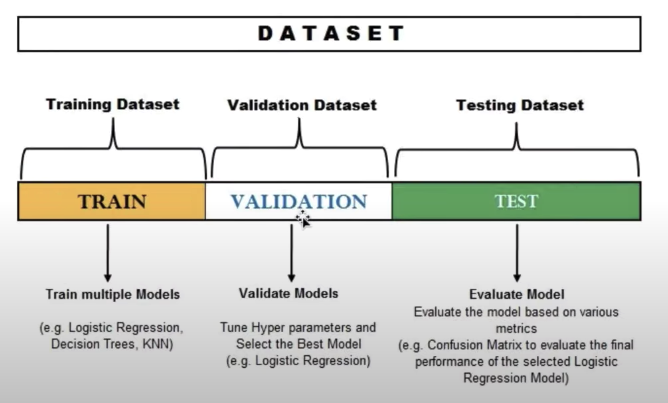

In [54]:
X = df.drop(['Outcome'], axis=1)
y = df['Outcome']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

Xây dựng model

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_val, y_val))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                144       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
62/62 [==============================] - 2s 7ms/step - loss: 1.5768 - accuracy: 0.5601 - val_loss: 0.9109 - val_accuracy: 0.6016
Epoch 2/100
62/62 [==============================] - 0s 4ms/step - loss: 1.0408 - accuracy: 0.5967 - val_loss: 1.1059 - val_accuracy: 0.6260
Epoch 3/100
62/62 [===================

In [ ]:
model.save("model.h5")

In [ ]:
model = load_model("model.h5")

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

## Sử dụng Hyperparameter Tuning (Keras Tuner)

In [ ]:
!pip install keras-tuner
import keras_tuner as kt

In [ ]:
# Tạm hàm build Hyper model
def build_model(hp): 
  model = keras.Sequential()

  X = hp.Int('units_input', min_value=8, max_value=64, step=8)
  model.add(Dense(units=X, input_dim=8, activation='relu'))

  for i in range(hp.Int('num_layers', 1, 4)):
    Y = hp.Int('units_' + str(i), min_value=8, max_value=64, step=8)
    model.add(Dense(units=Y, activation='relu'))

  model.add(Dense(1, activation='sigmoid'))

  lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy'])
  
  return model

In [ ]:
# Khởi tạo Tuner
tuner = kt.Hyperband (build_model, objective="val_accuracy", directory="tuner_dir_1", project_name="MLE501_Tuner_1")

In [ ]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

In [ ]:
# lấy best model
best_model = tuner.get_best_models(num_models=1)[0]

best_model.summary()

best_model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_val, y_val))

In [ ]:
best_model.save("best_model_hp.h5")

In [ ]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print("Best model using Hyperparameter Tuning")
print("Loss: ", loss)
print("Accuracy: ", accuracy)

model = load_model("model.h5")
loss, accuracy = model.evaluate(X_test, y_test)
print("Original model")
print("Loss: ", loss)
print("Accuracy: ", accuracy)

### So với model ban đầu, model được cải tiến bằng Hyperparameter Tuning đã có sự cải thiện về độ chính xác. Sự thay đổi tạo ra từ việc các Hyperparameter đã được tối ưu có chọn lọc.




In [ ]:
# Từ ban đầu model chỉ có 3 lớp với các thông số như sau:
model.summary()

In [ ]:
# Model sau khi được tối ưu có 6 lớp với các thông số sau:
best_model.summary()

## Sử dụng Regularization (L2 Regularization)

In [ ]:
from keras import regularizers

In [ ]:
#áp dụng  với hệ số lambda là 0.01 cho cả 2 lớp Dense đầu tiên của kiến trúc mạng neural. 

model = Sequential()
model.add(Dense(16, input_dim=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_val, y_val))

In [ ]:
model.save("best_model_regularization.h5")

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Best model using Regularization (L2 Regularization)")
print("Loss: ", loss)
print("Accuracy: ", accuracy)

original = load_model("model.h5")
loss, accuracy = original.evaluate(X_test, y_test)
print("Original model")
print("Loss: ", loss)
print("Accuracy: ", accuracy)

### So với model ban đầu, model được cải tiến bằng Regularization đã có sự cải thiện về độ chính xác, cụ thể ở đây em dùng kỹ thuật L2 Regularization. Sự thay đổi tạo ra từ việc thêm một thành phần bình phương của các trọng số vào hàm mất mát. Việc này sẽ làm cho các trọng số nhỏ hơn, dẫn đến mô hình đơn giản hơn và tránh được việc bị overfitting.

## Sử dụng Optimization (Adam -> RMSprop)

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_val, y_val))

In [ ]:
model.save("best_model_optimization.h5")

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Best model using Optimization (Adam -> RMSprop)")
print("Loss: ", loss)
print("Accuracy: ", accuracy)

original = load_model("model.h5")
loss, accuracy = original.evaluate(X_test, y_test)
print("Original model")
print("Loss: ", loss)
print("Accuracy: ", accuracy)

### So với model ban đầu, model được cải tiến bằng Regularization đã có sự cải thiện về độ chính xác, cụ thể ở đây em thay đổi optimizer từ Adam sang RMSprop. Thuật toán tối ưu mô hình sẽ thay đổi cách tính toán gradient và cập nhật trọng số trong quá trình huấn luyện. Cụ thể, hai thuật toán này sử dụng hai phương pháp khác nhau để tính toán gradient và cập nhật trọng số, do đó việc thay đổi optimizer sẽ có tác động đến hiệu suất của mô hình.

## Kết hợp cả 3 kỹ thuật

In [ ]:
# Tạm hàm build Hyper model
def build_best_model(hp): 
  model = keras.Sequential()

  X = hp.Int('units_input', min_value=8, max_value=64, step=8)
  model.add(Dense(units=X, input_dim=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

  for i in range(hp.Int('num_layers', 1, 4)):
    Y = hp.Int('units_' + str(i), min_value=8, max_value=64, step=8)
    model.add(Dense(units=Y, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

  model.add(Dense(1, activation='sigmoid'))

  # Tìm kiếm optimizer
  optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])

  # Tìm kiếm learning_rate
  lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  if optimizer == 'adam':
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
  else:
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=lr), metrics=['accuracy'])
  
  return model

In [ ]:
# Khởi tạo Tuner
tuner = kt.Hyperband (build_best_model, objective="val_accuracy", directory="tuner_dir_2", project_name="MLE501_Tuner_2")

In [ ]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

In [ ]:
# Lấy ra các tham số
best_hps = tuner.get_best_hyperparameters()[0]

print("units_input: ", best_hps.get('units_input'))
print("num_layers: ", best_hps.get('num_layers'))
print("optimizer: ", best_hps.get('optimizer'))
print("learning_rate: ", best_hps.get('learning_rate'))

In [ ]:
# lấy super model
best_model = tuner.get_best_models(num_models=1)[0]

best_model.summary()

best_model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_val, y_val))

In [ ]:
best_model.save("best_model_super.h5")